In [1]:
!which pip
!pip freeze | grep albumentations
!which python

/workspace/kaggle-notebooks/ink-detection/venv/bin/pip
albumentations==1.3.0
/workspace/kaggle-notebooks/ink-detection/venv/bin/python


## Import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import os
from torchvision.transforms import ToPILImage
import albumentations as A
import timm

/workspace/kaggle-notebooks/ink-detection/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [3]:
class EnvironmentConfig:
    base_path = "/workspace/kaggle-notebooks/ink-detection"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_path = os.path.join(base_path, "train")

class DnnConfig:
    epochs = 5
    lr = 1e-4
    batch_size = 64
    image_size = 128
    use_amp = True
    
class DomainConfig:
    buffer = 30
    z_start = 27
    z_dim = 10

class Config:
    environment = EnvironmentConfig()    
    dnn = DnnConfig()
    domain = DomainConfig()



In [4]:
TRAIN_CONFIG = Config()
TEST_CONFIG = Config()

base_index = os.environ.get("INDEX")
if base_index is None:
    base_index = "1"
MODE = "train"
PREFIX = os.path.join(TRAIN_CONFIG.environment.base_path, MODE, base_index)
BUFFER = TRAIN_CONFIG.domain.buffer
Z_START = TRAIN_CONFIG.domain.z_start # First slice in the z direction to use
Z_DIM = TRAIN_CONFIG.domain.z_dim   # Number of slices in the z direction
LEARNING_RATE = TRAIN_CONFIG.dnn.lr
BATCH_SIZE = TRAIN_CONFIG.dnn.batch_size
EPOCHS = TRAIN_CONFIG.dnn.epochs
DEVICE = TRAIN_CONFIG.environment.device
IMSIZE = TRAIN_CONFIG.dnn.image_size

USE_AMP = TRAIN_CONFIG.dnn.use_amp


## Dataset

In [5]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack: torch.Tensor, label, pixels, transform):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
        self.transform = transform
        
    def __len__(self):
        return len(self.pixels)
    
    def __getitem__(self, index):
        y, x = self.pixels[index]        
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        if self.transform is not None:
            # TODO: Support transforms
            pass
        return subvolume, inklabel

## Transforms

In [6]:
transforms_train = A.Compose([
    A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=10,p=0.5),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                             val_shift_limit=0.2, p=0.5),
       A.RandomBrightnessContrast(brightness_limit=0.2, 
                                  contrast_limit=0.2, p=0.5),
    ],p=0.9),
    A.Cutout(num_holes=12, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
    A.HorizontalFlip(p=0.5),   
    A.Resize(IMSIZE, IMSIZE, p=1.0), 
])
transforms_val = A.Compose([A.Resize(IMSIZE, IMSIZE, p=1.0)])

/workspace/kaggle-notebooks/ink-detection/venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## Model

In [7]:
class Model(nn.Module):
    def __init__(self, name, pretrained=True):
        super().__init__()

        # # Use timm
        # model = timm.create_model(name, pretrained=pretrained)

        # clsf = model.default_cfg['classifier']
        # n_features = model._modules[clsf].in_features
        # model._modules[clsf] = nn.Identity()

        # self.fc = nn.Sequential(
        #     nn.Linear(n_features, 32),
        #     nn.Linear(32, 1)
        # )
        
        model = nn.Sequential(
            nn.Conv3d(1, 32, 3, 1, 1), nn.BatchNorm3d(32), nn.MaxPool3d(2, 2),
            nn.Conv3d(32, 128, 3, 1, 1), nn.BatchNorm3d(128), nn.MaxPool3d(2, 2),
            nn.Flatten(start_dim=1),
        )
        fc = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        self.model = model
        self.fc = fc

    def forward(self, x):
        out = self.model(x)
        out = self.fc(out)
        return out

In [8]:
timm.list_models("*efficientnetv2*", pretrained=True)

['efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k',
 'tf_efficientnetv2_xl_in21ft1k',
 'tf_efficientnetv2_xl_in21k']

In [9]:
model = Model(name="efficientnetv2_rw_t").to(DEVICE)
# model = nn.DataParallel(model).to(DEVICE)

/workspace/kaggle-notebooks/ink-detection/venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Create Resources

100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


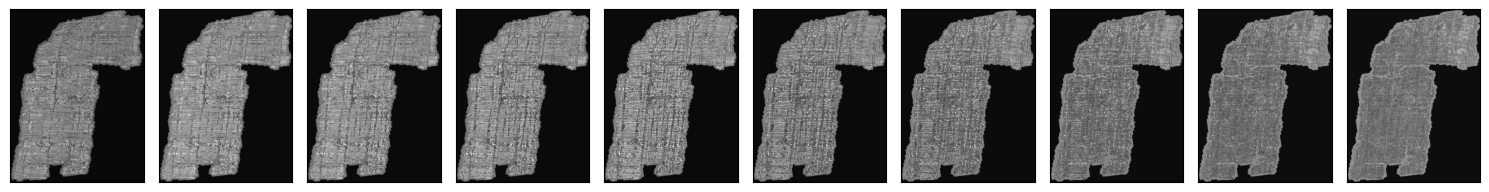

In [10]:
# Load the 3d x-ray scan, one slice at a time
images = [
  np.array(
    Image.open(
      filename
    ),
    dtype=np.float32
  ) / 65535.0
  for filename in tqdm(sorted(glob.glob(os.path.join(PREFIX, "surface_volume", "*.tif")))[Z_START:Z_START+Z_DIM])
]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Train

In [11]:
mask = np.array(Image.open(PREFIX+"/mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"/inklabels.png"))).gt(0).float().to(DEVICE)

rect = (1100, 3500, 700, 950)
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')

# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge
    if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

In [12]:
dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect, transforms_train)
dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=len(dataloader)//BATCH_SIZE)

In [13]:
def train_epoch(loader, optimizer, loss_func, scaler):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for subvolume, inklabel in bar:
        subvolume, inklabel = subvolume.to(DEVICE).float(), inklabel.to(DEVICE).float()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(subvolume)    
            loss = loss_func(logits, inklabel)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return np.mean(train_loss)

train_epoch(dataloader, optimizer, loss_func, scaler)

loss: 0.04470, smth: 0.17754: 100%|██████████| 444849/444849 [3:21:31<00:00, 36.79it/s]  


0.25367603

## Validation

In [14]:
def val_epoch(loader, loss_func) -> float:
    model.eval()
    val_loss = []

    with torch.no_grad():
        for (subvolume, inklabel) in tqdm(loader):
            subvolume, inklabel = subvolume.to(DEVICE).float(), inklabel.to(DEVICE).float()
            logits = model(subvolume)
            loss = loss_func(logits, inklabel)
            val_loss.append(loss.detach().cpu().numpy())
            
        val_loss = np.mean(val_loss)
    return val_loss


In [ ]:
torch.save(model.state_dict(), "model.pth")